In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Read raw data files and convert them to formatted data.

In [21]:
folder_path = 'VLSP2023_ComOM_training_v2'
files = os.listdir(folder_path)

sentences_and_content = []

for file_name in files:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        sections = file.read().split('\n\n')
        for section in sections:
            parts = section.split('\n')
            json_format = ""
            if len(parts) >= 2:
                sentence = parts[0].strip()
                sentence = sentence.split('\t')[-1]
                sentence = " ".join(sentence.split())
                sentence += '\t' + '1'

                for i in range(1, len(parts)):
                    contents = parts[i].strip()
                    json_contents = contents.strip().split('\n')
                    combined_format = sentence + '\n'
                    for json_content in json_contents:
                        idx_s, idx_e = (-1, -1)
                        tuples = ""
                        while True:
                            idx_s = json_content.find('[', idx_s + 1)
                            idx_e = json_content.find(']', idx_e + 1)

                            if idx_s == -1:
                                break

                            for i in json_content[idx_s:idx_e + 1]:
                                if i != ',':
                                    tuples += i

                            tuples += ';'

                        labels = ["DIF", "EQL", "SUP+", "SUP-", "SUP", "COM+", "COM-", "COM"]

                        for label in labels:
                            if json_content.find(label) != -1:
                                if label == "DIF":
                                    tuples += '[' + str(-1) + ']'
                                elif label == "EQL":
                                    tuples += '[' + str(0) + ']'
                                elif label == "SUP+":
                                    tuples += '[' + str(1) + ']'
                                elif label == "SUP-":
                                    tuples += '[' + str(2) + ']'
                                elif label == "SUP":
                                    tuples += '[' + str(3) + ']'
                                elif label == "COM+":
                                    tuples += '[' + str(4) + ']'
                                elif label == "COM-":
                                    tuples += '[' + str(5) + ']'
                                elif label == "COM":
                                    tuples += '[' + str(6) + ']'
                                break

                        json_format += '[' + tuples + ']' + '\n'
                        json_format = json_format.replace('"', '')
                combined_format += json_format[:-1]
                sentences_and_content.append(combined_format)

            else:
                sentence = parts[0].split('\t')
                if len(sentence) == 1:
                    continue
                else:
                    sentence = sentence[-1]
                if len(sentence.split()) == 2 and sentence.split()[1] in [':', '.', '?', '!', '...', '…', '….']:
                    continue
                
                sentence = " ".join(sentence.split())
                sentence += '\t' + '0'
                json_format = "[[];[];[];[];[]]"
                combined_format = f"{sentence}\n{json_format}"
                sentences_and_content.append(combined_format)
                    
    if file_name == 'dev_0024.txt':    
        with open('dev.txt', 'w', encoding='utf-8') as output_file:
            for item in sentences_and_content:
                output_file.write(str(item) + '\n')
        sentences_and_content = []
    elif file_name == 'train_0060.txt':
        with open('train.txt', 'w', encoding='utf-8') as output_file:
            for item in sentences_and_content:
                output_file.write(str(item) + '\n')
        sentences_and_content = []
    elif file_name == 'test_0036.txt':
        with open('test.txt', 'w', encoding='utf-8') as output_file:
            for item in sentences_and_content:
                output_file.write(str(item) + '\n')
        sentences_and_content = []

Count sentences, and labeled sentences

In [3]:
def clear_string(line, strip_symbol=None, replace_symbol=None):
    """
    :param line: a string
    :param strip_symbol:
    :param replace_symbol: a list of special symbol, need replace.
    :return:
    """
    if strip_symbol is not None:
        for sym in strip_symbol:
            line = line.strip(sym)

    if replace_symbol is not None:
        for sym in replace_symbol:
            line = line.replace(sym, "")

    return line

In [4]:
def read_standard_file(path):
    """
    :param path:
    :return: sent_col, sent_label_col and label_col
    """
    sent_col, sent_label_col, final_label_col = [], [], []
    last_sentence = ""
    with open(path, "r", encoding="utf-8") as f:
        for line in f.readlines():
            line = line.rstrip('\n')

            # "[[" denote the begin of sequence label.
            if line[:2] == "[[":
                label_col.append(line)

            else:
                if last_sentence != "":
                    last_sentence = last_sentence.strip()
                    # cur_sent, cur_sent_label = shared_utils.split_string(last_sentence, '\t')
                    cur_sent_label = last_sentence[-1]
                    cur_sent = last_sentence[:-1].strip()
                    
                    sent_col.append(cur_sent)
                    sent_label_col.append(int(cur_sent_label))
                    final_label_col.append(label_col)

                last_sentence = clear_string(line, replace_symbol={u'\u3000': u""})
                label_col = []

        # cur_sent, cur_sent_label = shared_utils.split_string(last_sentence, '\t')
        last_sentence = last_sentence.strip()
        cur_sent_label = last_sentence[-1]
        cur_sent = last_sentence[:-1].strip()
        
        sent_col.append(cur_sent)
        sent_label_col.append(int(cur_sent_label))
        final_label_col.append(label_col)

        return sent_col, sent_label_col, final_label_col

In [22]:
sent_col, sent_label_col, final_label_col = read_standard_file("train.txt")
df_train = pd.DataFrame({"sentence": sent_col, "label": sent_label_col, "label_col": final_label_col})
sent_col, sent_label_col, final_label_col = read_standard_file("dev.txt")
df_dev = pd.DataFrame({"sentence": sent_col, "label": sent_label_col, "label_col": final_label_col})
sent_col, sent_label_col, final_label_col = read_standard_file("test.txt")
df_test = pd.DataFrame({"sentence": sent_col, "label": sent_label_col, "label_col": final_label_col})

In [23]:
comp_train = df_train[df_train['label'] == 1]
non_comp_train = df_train[df_train['label'] == 0]
multi_comp_train = df_train[df_train['label_col'].apply(len) > 1]

comp_dev = df_dev[df_dev['label'] == 1]
non_comp_dev = df_dev[df_dev['label'] == 0]
multi_comp_dev = df_dev[df_dev['label_col'].apply(len) > 1]

comp_test = df_test[df_test['label'] == 1]
non_comp_test = df_test[df_test['label'] == 0]
multi_comp_test = df_test[df_test['label_col'].apply(len) > 1]


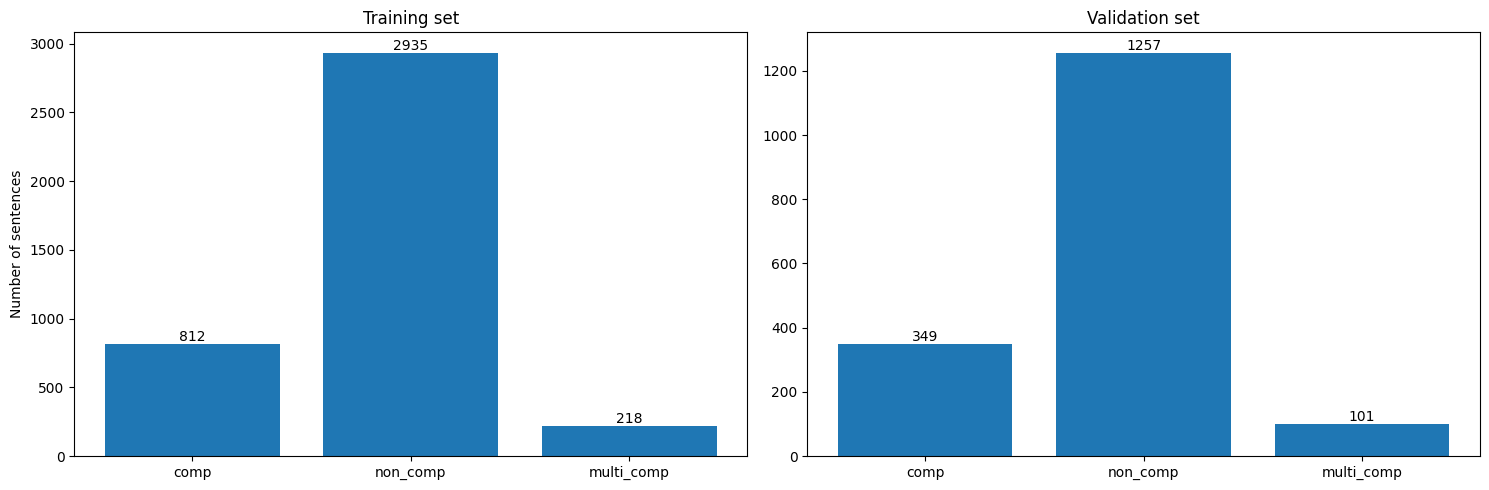

In [7]:
contents_train = [len(comp_train), len(non_comp_train), len(multi_comp_train)]
contents_dev = [len(comp_dev), len(non_comp_dev), len(multi_comp_dev)]
names = ['comp', 'non_comp', 'multi_comp']

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Create the first bar graph
bars1 = axs[0].bar(names, contents_train)
for i, bar in enumerate(bars1):
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), contents_train[i], ha='center', va='bottom')
axs[0].set_title('Training set')
axs[0].set_ylabel('Number of sentences')

# Create the second bar graph
bars2 = axs[1].bar(names, contents_dev)
for i, bar in enumerate(bars2):
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), contents_dev[i], ha='center', va='bottom')
axs[1].set_title('Validation set')

# Display the graphs
plt.tight_layout()
plt.show()

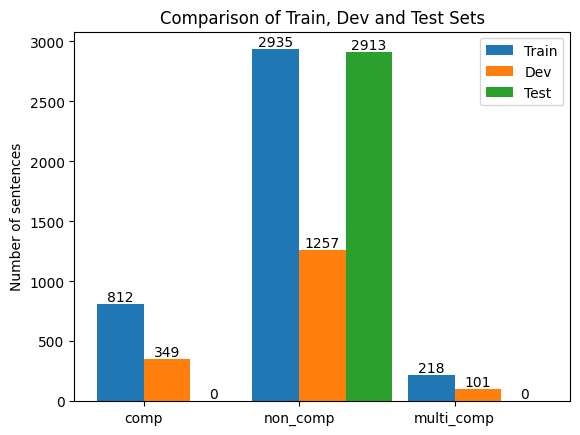

In [26]:
contents_train = [len(comp_train), len(non_comp_train), len(multi_comp_train)]
contents_dev = [len(comp_dev), len(non_comp_dev), len(multi_comp_dev)]
contents_test = [len(comp_test), len(non_comp_test), len(multi_comp_test)]

names = ['comp', 'non_comp', 'multi_comp']

# Define the width of the bars and the positions of the x-ticks for the first bar
width = 0.3  # the width of the bars
x = np.arange(len(names))  # the x locations for the groups

# Create the first bar graph
bars_train = plt.bar(x - width/2, contents_train, width, label='Train')

# Add numbers on top of each bar
for i, bar in enumerate(bars_train):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), contents_train[i], ha='center', va='bottom')
    
# Create the second bar graph with a shift in the x-coordinates
bars_dev = plt.bar(x + width/2, contents_dev, width, label='Dev')

# Add numbers on top of each bar
for i, bar in enumerate(bars_dev):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), contents_dev[i], ha='center', va='bottom')
    
bars_test = plt.bar(x + width/2 + width, contents_test, width, label='Test')

# Add numbers on top of each bar
for i, bar in enumerate(bars_test):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), contents_test[i], ha='center', va='bottom')

# Set the title and labels
plt.title('Comparison of Train, Dev and Test Sets')
plt.ylabel('Number of sentences')
plt.xticks(x, names)  # set the x-ticks to be the names

# Add a legend
plt.legend()

# Display the graph
plt.show()

In [16]:
def element_count(df):
    sub, obj, ca, co, cp = set(), set(), set(), set(), []
    for sentences in df:
        for sentence in sentences:
            elements = sentence.split(';')
            for i, labels in enumerate(elements):
                word = ""
                for label in labels.split(' '):
                    if label.find('&&') == -1:
                        continue
                    if label[-1] != ']':
                        word += label[label.find('&&')+2:] + ' '
                    else:
                        word += label[label.find('&&')+2:-1]
                word = word.strip()
                if i == 0:
                    sub.add(word)
                elif i == 1:
                    obj.add(word)
                elif i == 2:
                    ca.add(word)
                elif i == 3:
                    co.add(word)
                elif i == 4:
                    if len(labels) == 3:
                        cp.append(labels[1])
                    else: 
                        cp.append(labels[1:-2])
    return sub, obj, ca, co, cp

In [17]:
sub_train, obj_train, ca_train, co_train, cp_train = element_count(comp_train['label_col'])
sub_dev, obj_dev, ca_dev, co_dev, cp_dev = element_count(comp_dev['label_col'])

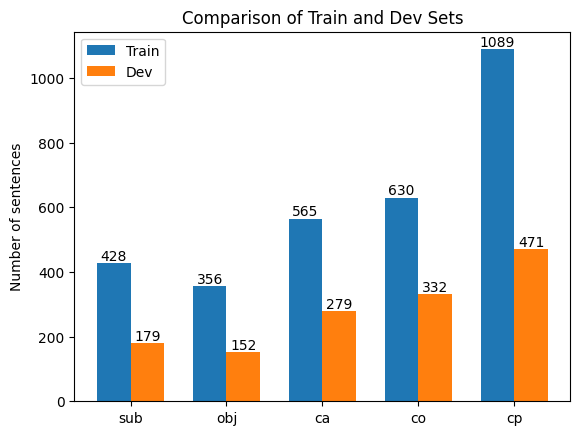

In [18]:
elements_train = [len(sub_train), len(obj_train), len(ca_train), len(co_train), len(cp_train)]
elements_dev = [len(sub_dev), len(obj_dev), len(ca_dev), len(co_dev), len(cp_dev)]
names = ['sub', 'obj', 'ca', 'co', 'cp']

# Define the width of the bars and the positions of the x-ticks for the first bar
width = 0.35  # the width of the bars
x = np.arange(len(names))  # the x locations for the groups

# Create the first bar graph
bars_train = plt.bar(x - width/2, elements_train, width, label='Train')

# Add numbers on top of each bar
for i, bar in enumerate(bars_train):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), elements_train[i], ha='center', va='bottom')
    
# Create the second bar graph with a shift in the x-coordinates
bars_dev = plt.bar(x + width/2, elements_dev, width, label='Dev')

# Add numbers on top of each bar
for i, bar in enumerate(bars_dev):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), elements_dev[i], ha='center', va='bottom')
    
# Set the title and labels
plt.title('Comparison of Train and Dev Sets')
plt.ylabel('Number of sentences')
plt.xticks(x, names)  # set the x-ticks to be the names

# Add a legend
plt.legend()

# Display the graph
plt.show()

In [19]:
DIF_train = cp_train.count('-1')
EQL_train = cp_train.count('0')
SUP_plus_train = cp_train.count('1')
SUP_minis_train = cp_train.count('2')
SUP_train = cp_train.count('3')
COM_plus_train = cp_train.count('4')
COM_minus_train = cp_train.count('5')
COM_train = cp_train.count('6')

DIFF_dev = cp_dev.count('-1')
EQL_dev = cp_dev.count('0')
SUP_plus_dev = cp_dev.count('1')
SUP_minis_dev = cp_dev.count('2')
SUP_dev = cp_dev.count('3')
COM_plus_dev = cp_dev.count('4')
COM_minus_dev = cp_dev.count('5')
COM_dev = cp_dev.count('6')

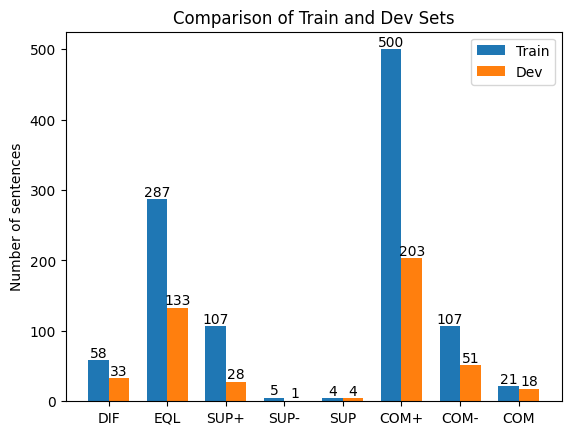

In [20]:
labels_train = [DIF_train, EQL_train, SUP_plus_train, SUP_minis_train, SUP_train, COM_plus_train, COM_minus_train, COM_train]
labels_dev = [DIFF_dev, EQL_dev, SUP_plus_dev, SUP_minis_dev, SUP_dev, COM_plus_dev, COM_minus_dev, COM_dev]
labels = ["DIF", "EQL", "SUP+", "SUP-", "SUP", "COM+", "COM-", "COM"]

# Define the width of the bars and the positions of the x-ticks for the first bar
width = 0.35  # the width of the bars
x = np.arange(len(labels))  # the x locations for the groups

# Create the first bar graph
bars_train = plt.bar(x - width/2, labels_train, width, label='Train')

# Add numbers on top of each bar
for i, bar in enumerate(bars_train):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), labels_train[i], ha='center', va='bottom')
    
# Create the second bar graph with a shift in the x-coordinates
bars_dev = plt.bar(x + width/2, labels_dev, width, label='Dev')

# Add numbers on top of each bar
for i, bar in enumerate(bars_dev):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), labels_dev[i], ha='center', va='bottom')
    
# Set the title and labels
plt.title('Comparison of Train and Dev Sets')
plt.ylabel('Number of sentences')
plt.xticks(x, labels)  # set the x-ticks to be the names

# Add a legend
plt.legend()

# Display the graph
plt.show()